# CounterFactual (Basic) Explainer

This Notebook is a tutorial on how to use the Basic Counter Factual (Panellet) Explainer using the Iris dataset as example.

In short, the Panellet Explainer assumes a model $M$ which has been trained with a dataset $D$. Then, it tries to answer a question of the following type:
"I have an instance $x$ which the model is predicting a probability $p$ of belonging to the class $C$. What are the necessary changes in the features of the instance $x$ that will make the model predict a different specified probability $p^{\prime}$ of belonging to the class $C$ ?



## Setup

To execute this tutorial, you need to install mercury-explainability (if they are not already installed). You can install it by executing the next command in a cell:

```
!pip install mercury-explainability
```

In [1]:
import numpy as np
from sklearn import datasets
from sklearn import ensemble
from matplotlib import pyplot as plt
%matplotlib inline

from mercury.explainability import CounterFactualExplainerBasic

## Data loading and model fitting

Let's load the [iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set) to train a complex Random Forest and check some explanations:

In [2]:
iris = datasets.load_iris()
rf = ensemble.RandomForestClassifier(n_estimators=500)
rf = rf.fit(iris.data, iris.target)

Define a starting point to explain:

In [3]:
class_idx = 2
from_ = np.array([5.2, 2.1, 2.2, 2.1])
print('Point to explain {}, with probability {} for class {}'.format(
    from_, rf.predict_proba(from_.reshape(1, -1))[0, class_idx], iris.target_names[class_idx]))

Point to explain [5.2 2.1 2.2 2.1], with probability 0.272 for class virginica


## Create Basic (Panellet) Explainer

The first step is create the ```CounterFactualExplainerBasic``` with:

 - Dataset (in order to infer boundaries for each dimension).
 - Prediction function of the model we want to explain.
 - Labels of each dimension.

In [4]:
p_explainer = CounterFactualExplainerBasic(iris.data, fn=rf.predict_proba, labels=iris.feature_names)

Then, we use the ```CounterFactualExplainerBasic``` to obtain a explanation using:
 - **From** a starting point (the one that we want to explain).
 - **Threshold** that we would like to reach increasing/decreasing values in each dimensions.
 - **Class index** of desired probability.
 - Absolute **Step** in each dimension (feature).

In [5]:
explanation = p_explainer.explain(from_=from_,
                                  threshold=.9,
                                  class_idx=class_idx,
                                  step=np.array([.1] * 4))
print('Found point with {} probability @ {}'.format(explanation.p, explanation.to_))

Found point with 0.928 probability @ [4.8 2.5 5.  2. ]


## Show the explanation

Let's see what ```CounterFactualExplainerBasic``` has just found (```CounterFactualBasicExplanation``` object):

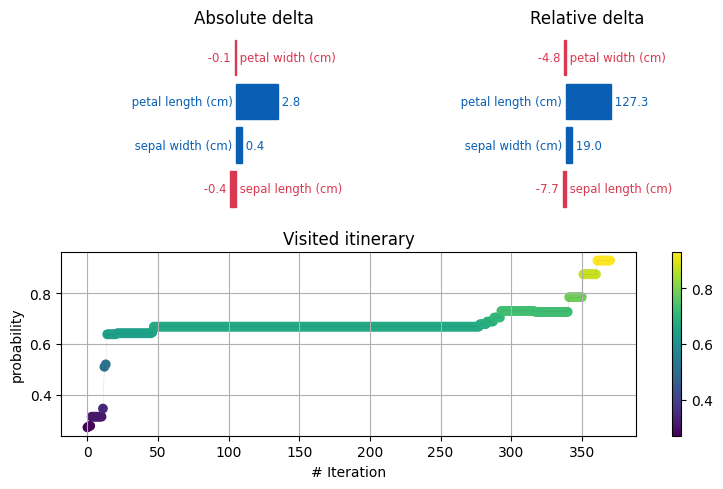

In [6]:
explanation.show(figsize=(8, 5))

Where the firsts two plots show how much each feature should be incremented/decremented to reach provided target (```threshold```) for ```class_idx```.

The last one shows the probability of each visited path along its trip.

### [Optional] Let's see the visited feature space to obtain the explanation

Once again, train a classifier but only with 2 features (sepals), in order to plot the probability space, and get the explanation one more time.

In [7]:
class_idx = 1
from_ = np.array([6.2, 4.1])

rf = ensemble.RandomForestClassifier(n_estimators=500)
rf = rf.fit(iris.data[:, :2], iris.target)

In [8]:
p_explainer = CounterFactualExplainerBasic(iris.data[:, :2], fn=rf.predict_proba, labels=iris.feature_names[:2])

explanation = p_explainer.explain(from_=from_,
                                  threshold=.9,
                                  class_idx=class_idx,
                                  step=np.array([.05, .05]))

Query the probability space for every combination of sepals in order to get its probability for ```class_idx```.

In [9]:
min_, max_ = np.min(iris.data, axis=0), np.max(iris.data, axis=0)
X, Y = np.meshgrid(np.arange(min_[0], max_[0], .025), np.arange(min_[1], max_[1], .025))

# Get probabilty of class 1 for each feature point in a vectorized fashion
z = rf.predict_proba(np.hstack([X.reshape(-1, 1), Y.reshape(-1, 1)]))[:,1].reshape(X.shape)

Plot visited points (white opaque dots) and explored points (small and almost transparent white dots) over the probability space. Visited and explored points can be retrieved from ```CounterFactualBasicExplanation``` object:

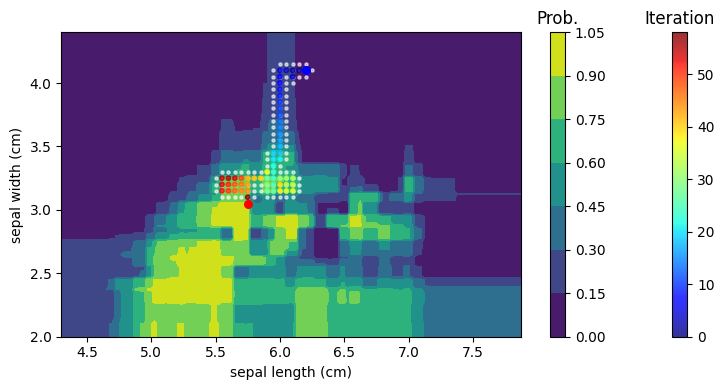

In [10]:
def plot_path(exp, boundary=False) -> None:
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    cb = ax.contourf(X, Y, z)
    if exp.explored is not None and exp.explored.size > 0:
        ax.scatter(exp.explored[:,0], exp.explored[:,1], c='w', s=5, alpha=.6)
    cb2 = ax.scatter(exp.path[:,0], exp.path[:,1],
                     c=range(exp.path.shape[0]), cmap='jet', s=10, alpha=.8)
    if boundary:
        bb = explanation.bounds
        ax.plot([bb[0,0], bb[0,1], bb[0,1], bb[0,0], bb[0,0]], [bb[1,0], bb[1,0], bb[1,1], bb[1,1], bb[1,0]],
                lw=3, c='m')
    ax.scatter(exp.from_[0], exp.from_[1], c='b', s=30)
    ax.scatter(exp.to_[0], exp.to_[1], c='r', s=30)
    pcb2 = plt.colorbar(cb2)
    pcb2.ax.set_title('Iteration')
    pcb1 = plt.colorbar(cb)
    pcb1.ax.set_title('Prob.')
    ax.set_xlabel(iris.feature_names[0])
    ax.set_ylabel(iris.feature_names[1])

    plt.tight_layout()

plot_path(explanation)

In this figure, the background represents the Random Forest output probability for each sepal length and sepal width combination.

White dots are explored points of the space and colored dots are visited points by the Panellet Explainer where its color is determined by the iteration number it was visited.

# Advanced Panellet Explanations

## Going from higher to lower probability!

Previous example started from am low probability point and goes to a high one. But sometimes you start from a high probability point and want to descend to a lower probability point. You do not have to do anything, the Panellet Explainer knows when to go up or down ;-)

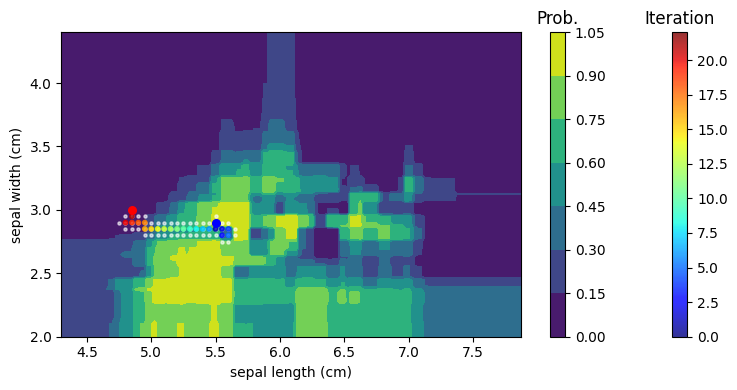

In [11]:
explanation = p_explainer.explain(from_=np.array([5.5, 2.9]), threshold=.1, class_idx=1, step=np.array([.05, .05]))

plot_path(explanation)

## Do not change specific features

Sometimes it is hard to explain a change in dimensions like "country". That is why Panellet Explainer introduces the *kernel* trick to avoid changes in chosen dimensions. Just revisit the previous example:

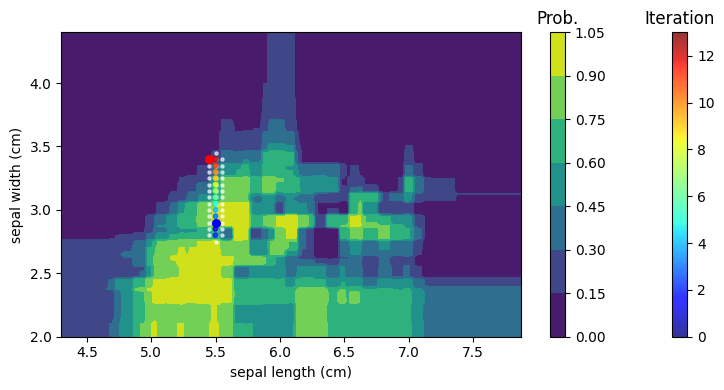

In [12]:
explanation = p_explainer.explain(from_=np.array([5.5, 2.9]), threshold=.1, class_idx=1,
                        step=np.array([.05, .05]), kernel=np.array([.3, 1]))

plot_path(explanation)

This time *x* dimension is highly penalized so the Panellet Explainer avoided moving along the x axis. But you can specify an intermediate value to kernel positions ir order to implement any kind of trade off.

## Specifying boundaries in feature space to explore

Sometimes is not easy to find target value close to the starting point and going far away is always an option!

By default, the Panellet Explainer does not move further away than your training data points (that is why training data is required when instantiating ```CounterFactualBasicExplainter``` object).

This is because there are implicit **boundaries** that you can make explicit to avoid the Panellet Explainer moving out of desired area.

Here is an example of the Panellet Explainer exploring in a restricted area:

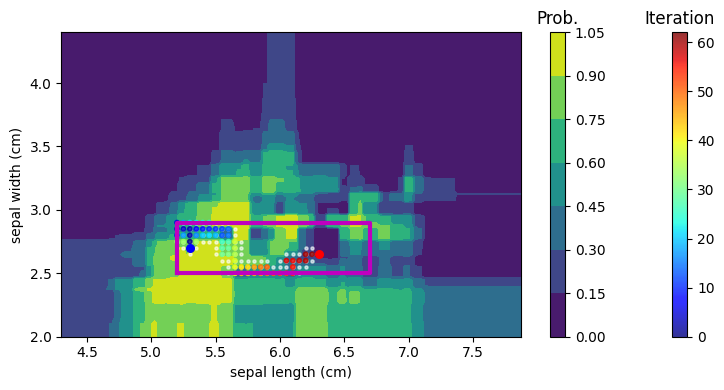

In [13]:
explanation = p_explainer.explain(from_=np.array([5.3, 2.7]), threshold=.2, class_idx=1,
                        step=np.array([.05, .05]), bounds=np.array([[5.2, 6.7], [2.5, 2.9]]))

plot_path(explanation, boundary=True)

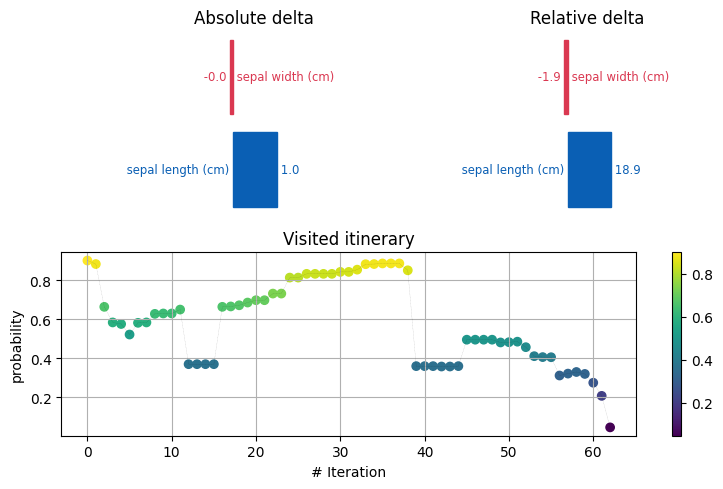

In [14]:
explanation.show(figsize=(8, 5))

## But I have a high dimensional space and obtaining explanations may take too long!

There are two available strategies to obtain explanations:

 - **Backtracking with priority queue** (default):
   - Path of connected neighbours
   - Tries to follow a monotonic increasing/decreasing path (avoid ups & downs, hard to explain)
   - Guarantees a border point if target is reached
   - May be slow if target is far from starting point
   - Step parameter can be increased to speed up the search
   
   
 - **Simulated annealing**:
   - Heuristic non-neighbours search (exploration & exploitation)
   - Does not guarantee a monotonic path, even if it exists
   - Does not guarantee a border point even when the target is reached
   - Faster than Backtracking approach when target is far from the starting point

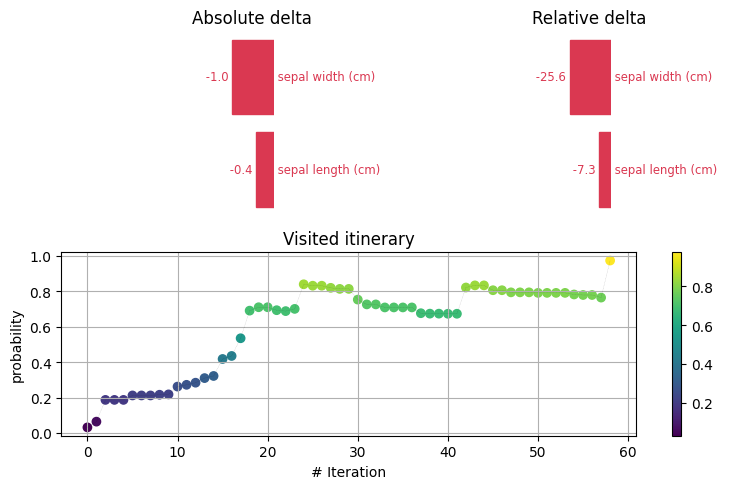

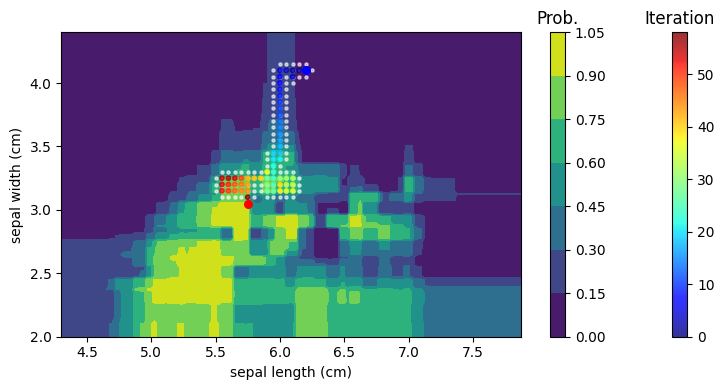

In [15]:
explanation = p_explainer.explain(from_=np.array([6.2, 4.1]),
                        strategy='backtracking',
                        threshold=.9,
                        class_idx=1,
                        step=np.array([.05, .05]))

explanation.show(figsize=(8, 5))
plot_path(explanation)

 Temperature        Energy    Accept   Improve     Elapsed   Remaining


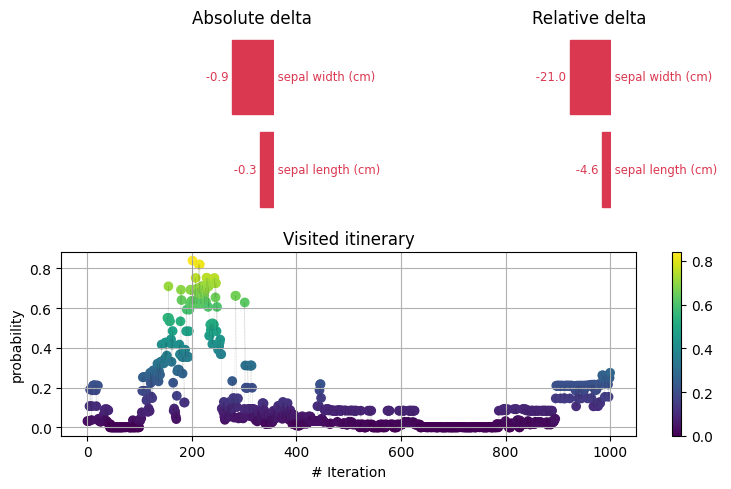

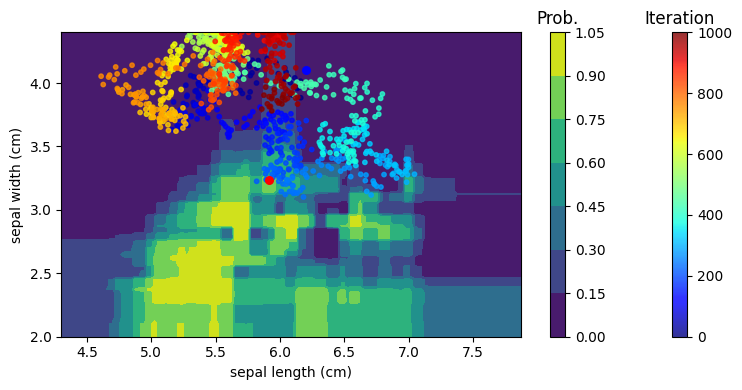

In [16]:
explanation = p_explainer.explain(from_=np.array([6.2, 4.1]),
                        strategy='simanneal',
                        threshold=.9,
                        class_idx=1,
                        step=np.array([.8, .8]),
                        report=True,
                        tmax=150,
                        tmin=1e-2,
                        steps=1000)

explanation.show(figsize=(8, 5))
plot_path(explanation)